In [8]:
import networkx as nx  # make sure you installed networkx
import pandas as pd
import numpy as np


In [9]:
# Read in data
df = pd.read_csv("../../data/edgelists/forwards_edgelist_corsi.csv")
players_df = pd.read_csv(
    "../../data/final/aggregated_forwards.csv", index_col='playerId', header=0)


In [10]:
# Create a network of nodes which are players and the links are players that played together
# We create 2 graphs, one for each relationship direction and then compose them for our total graph
df = df.rename(columns={'cf_inf_on2': 'weight'})
G0 = nx.Graph()
G0 = nx.from_pandas_edgelist(df, 'playerId1', 'playerId2', [
                             'weight'], create_using=nx.DiGraph)

df = df.rename(columns={'weight': 'notweight', 'cf_inf_on1': 'weight'})
G1 = nx.Graph()
G1 = nx.from_pandas_edgelist(
    df, 'playerId2', 'playerId1', edge_attr='weight', create_using=nx.DiGraph)

G = nx.compose(G0, G1)


In [11]:
# We are creating this graph specifically for community analysis, so we can clean up irrelevant nodes
# Delete edges with 0 or negative influence
edge_attrs = nx.get_edge_attributes(G, "weight")
for edge in edge_attrs.keys():
    if edge_attrs[edge] <= 0:
        G.remove_edge(edge[0], edge[1])

# Delete nodes with no edges
G.remove_nodes_from(list(nx.isolates(G)))


In [12]:
# Make a list of stats we want to look at for easier looping
interesting_stats = [
    'playerName',
    'games_played',
    'icetime',
    'timeOnBench',
    'onIce_corsiPercentage',
    'offIce_corsiPercentage',
    'on_off_corsi_diff',
    'OnIce_F_goals_per60',
    'OnIce_A_goals_per60',
    'I_F_dZoneGiveaways_per60',
    'I_F_giveaways_per60',
    'average_TOI',
    'I_F_hits_per60',
    'I_F_takeaways_per60',
    'I_F_points_per60',
    'shotsBlockedByPlayer_per60',
    'I_F_oZoneShiftStarts_per60',
    'I_F_dZoneShiftStarts_per60',
    'I_F_neutralZoneShiftStarts_per60',
    'I_F_flyShiftStarts_per60',
    'I_F_primaryAssists_per60',
    'I_F_secondaryAssists_per60',
    'I_F_goals_per60'
]


In [13]:
# Add data to nodes that may be useful for visualization
def copy_attr_to_nodes(G, df, attr_name):
    nodes_dict = dict.fromkeys(G.nodes)
    for node in G.nodes:
        node_attr = df.loc[[node]][attr_name].values[0]
        nodes_dict[node] = node_attr
    return nodes_dict


In [14]:
# Copy a whole bunch of relevant stats to nodes for easier data analysis
# Add player names to nodes
player_names = copy_attr_to_nodes(G, players_df, "playerName")
nx.set_node_attributes(G, player_names, "playerName")

# NOTE: this uses data calculated in defense-overall.ipynb
# average corsi influence
player_avg_inf = copy_attr_to_nodes(G, players_df, "average_corsi_influence")
nx.set_node_attributes(G, player_names, "average_corsi_influence")


In [15]:
# Number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print("Number of nodes: ", num_nodes)
print("Number of edges: ", num_edges)


Number of nodes:  758
Number of edges:  4442


In [16]:
# Run community detection algorithms, add info to graph and export to gephi for visualization
import networkx.algorithms.community as nxc

# Greedy Modularity
communities = nxc.greedy_modularity_communities(G, weight='weight')

# add community info to node attributes
i = 0
communities_dict = dict.fromkeys(G.nodes)
for community in communities:
    for player in community:
        communities_dict[player] = i
    i += 1

nx.set_node_attributes(G, communities_dict, "community")


In [17]:
# output a gephi file for ez visualization
nx.write_gexf(G, 'gexf_exports/forwards_positive.gexf')


In [18]:
# Display stat distributions and other relevant stuff to identify trends within and between communities
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

players_df = pd.read_csv(
    "../../data/final/aggregated_forwards.csv", index_col='playerId', header=0)

# Remove players with less than 20 games to clean up playerbase data a bit
players_df_pared = players_df.drop(
    players_df[players_df.icetime < 12000].index)


In [19]:
import scipy.stats as sps


def plot_distributions(stat):
    # Plot distribution of entire playerbase
    playerbase_stats = players_df_pared[stat].values
    pb_mean = np.nanmean(playerbase_stats)
    pb_dev = np.nanstd(playerbase_stats)
    print("n: ", len(playerbase_stats))
    print("mean: ", pb_mean)
    print("std dev: ", pb_dev)
    n, bins, patches = plt.hist(playerbase_stats, 30)
    plt.xlabel(stat)
    plt.ylabel("Count")
    plt.title("Overall Playerbase " + stat)
    plt.show()

    # Plot distribution of each community individually
    i = 0
    for community in communities:
        players_stats = []
        for player in community:
            players_stats.append(players_df.loc[player][stat])
        print("Community: ", i)
        print("n: ", len(players_stats))
        print("mean: ", np.mean(players_stats))
        print(sps.ttest_1samp(players_stats, pb_mean))
        # Reduce clutter for now
        # plt.hist(players_stats, bins)
        # plt.xlabel(stat)
        # plt.ylabel("Count")
        # title = "Community: " + str(i)
        # plt.title(title)
        # plt.show()
        i += 1


In [20]:
def dists(stat):
    pb_stats = players_df_pared[stat].values
    pb_mean = np.nanmean(pb_stats)

    i = 0
    j = 0
    coms = [0] * len(communities)
    for community in communities:
        p_stats = []
        for player in community:
            p_stats.append(players_df.loc[player][stat])
        statistic, pvalue = sps.ttest_1samp(p_stats, pb_mean)
        if pvalue < 0.05:
            j += 1
            coms[i] += 1
        i += 1

    prop = j / len(communities)
    return prop, coms


playerName
games_played
[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
icetime
[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0]
timeOnBench
[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
onIce_corsiPercentage
[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0]
offIce_corsiPercentage
[1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0]
on_off_corsi_diff
[0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
OnIce_F_goals_per60
[0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0]
OnIce_A_goals_per60
[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0]
I_F_dZoneGiveaways_per60
[1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0]
I_F_giveaways_per60
[1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
average_TOI
[0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0]
I_F_hits_per60
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1]
I_F_takeaways_per60
[1, 0, 0, 1, 0, 0, 0, 0, 0, 1

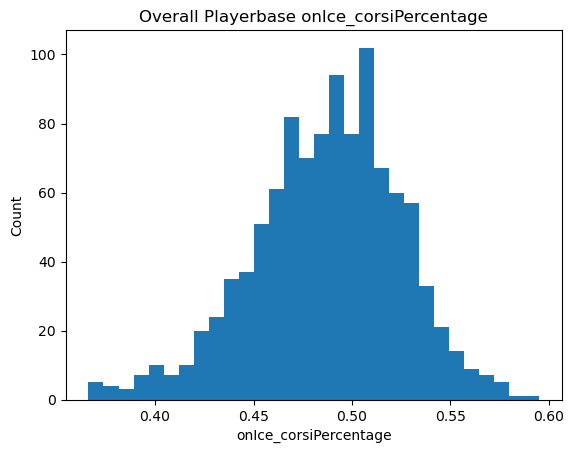

Community:  0
n:  66
mean:  0.4874437685894491
Ttest_1sampResult(statistic=0.04790843607116384, pvalue=0.9619361164056004)
Community:  1
n:  63
mean:  0.5062829797350847
Ttest_1sampResult(statistic=5.062966006288932, pvalue=3.954959997826015e-06)
Community:  2
n:  57
mean:  0.4889910200507862
Ttest_1sampResult(statistic=0.4886271767509272, pvalue=0.6270137798599478)
Community:  3
n:  56
mean:  0.4912060825140223
Ttest_1sampResult(statistic=1.0772511397245357, pvalue=0.28607047060201013)
Community:  4
n:  55
mean:  0.49732798407169554
Ttest_1sampResult(statistic=2.337628815129387, pvalue=0.023142508361637365)
Community:  5
n:  54
mean:  0.4934685481928597
Ttest_1sampResult(statistic=1.3239007697130447, pvalue=0.19121782799349735)
Community:  6
n:  51
mean:  0.49488500992413675
Ttest_1sampResult(statistic=1.5480513469000512, pvalue=0.12791679290290825)
Community:  7
n:  50
mean:  0.49235217168125606
Ttest_1sampResult(statistic=0.9846353582833914, pvalue=0.3296403148359316)
Community:  8


In [21]:
i = 0
for stat in interesting_stats:
    print(stat)
    if stat == 'playerName':
        continue
    gap, coms = dists(stat)
    i += gap
    print(coms)

print(i / len(interesting_stats))
# Plot corsi influence distribution of entire playerbase
plot_distributions("onIce_corsiPercentage")


In [22]:
# Numeric assortativity between nodes
# Check to see if the positive graph behaves differently than the complete one
def ordinal_stat_assortativity(G, players_df, stat):
    # Copy stat in question as node attribute first
    stats = copy_attr_to_nodes(G, players_df, stat)
    nx.set_node_attributes(G, stats, stat)
    return nx.numeric_assortativity_coefficient(G, attribute=stat)


for stat in interesting_stats:
    if stat == 'playerName':
        continue
    print(stat + ' assortativity: ',
          ordinal_stat_assortativity(G, players_df, stat))


games_played assortativity:  0.10550768131932581
icetime assortativity:  0.1362094467940885
timeOnBench assortativity:  0.09286956028630036
onIce_corsiPercentage assortativity:  0.41543297221445546
offIce_corsiPercentage assortativity:  0.48437482605568777
on_off_corsi_diff assortativity:  0.30281629816296396
OnIce_F_goals_per60 assortativity:  0.43756860734769126
OnIce_A_goals_per60 assortativity:  0.2875612100223652
I_F_dZoneGiveaways_per60 assortativity:  0.23105812122196892
I_F_giveaways_per60 assortativity:  0.2097989272291843
average_TOI assortativity:  0.34409066042769054
I_F_hits_per60 assortativity:  0.18243093475166217
I_F_takeaways_per60 assortativity:  0.14788380015237662
I_F_points_per60 assortativity:  0.32609041915958903
shotsBlockedByPlayer_per60 assortativity:  0.11807608225629788
I_F_oZoneShiftStarts_per60 assortativity:  0.3888681696271737
I_F_dZoneShiftStarts_per60 assortativity:  0.2895820856636092
I_F_neutralZoneShiftStarts_per60 assortativity:  0.2314887582780573